In [1]:
import numpy as np, matplotlib.pyplot as plt,\
librosa as lr, librosa.display
from IPython.display import Audio

# More Audio Features

Bisher:

- amplitude-envelope
- RMS-energy
- STFT (= Spektrogramm)
- Chromagramm
- Zero Crossing Rate

In [2]:
sr = 44100

y_v, _ = lr.load('../../data/snd/violin.wav', sr=sr)
display(Audio(y_v, rate=sr))

y_p, _ = lr.load('../../data/snd/piano_scale.mp3', sr=sr)
display(Audio(y_p, rate=sr))

/Users/danielhopfner/miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


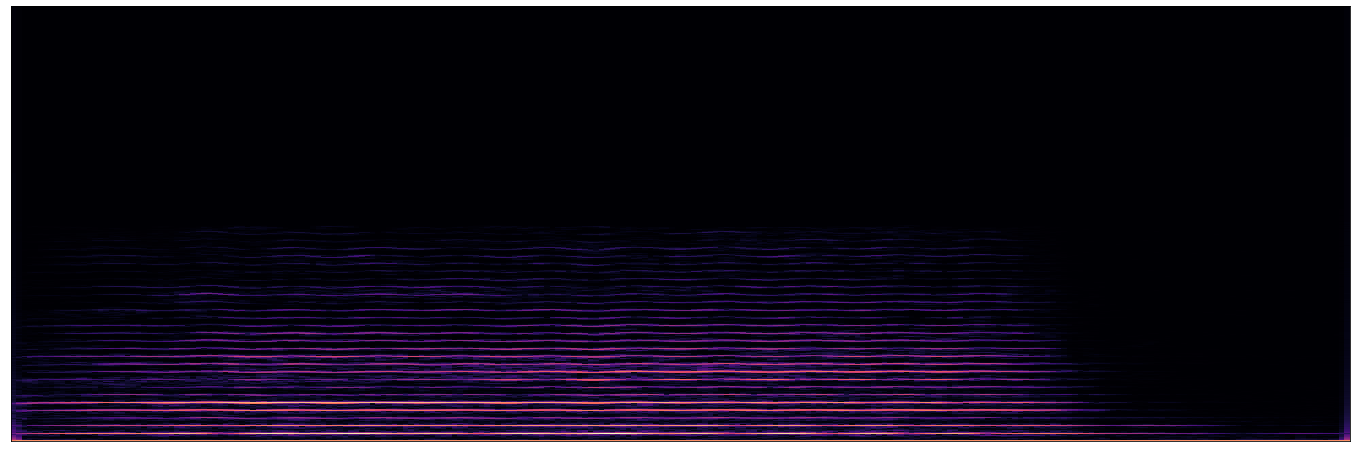

In [3]:
stft_v = lr.stft(y=(y_v + 0.02)) # ein bisschen dc-offset, um das grundrauschen zu umgehen

mag_stft_v = np.abs(stft_v)

gamma = 10
mag_stft_gamma_v = np.log10(1 + mag_stft_v * gamma)

plt.figure(figsize=(24, 8))
lr.display.specshow(mag_stft_gamma_v)
plt.show()

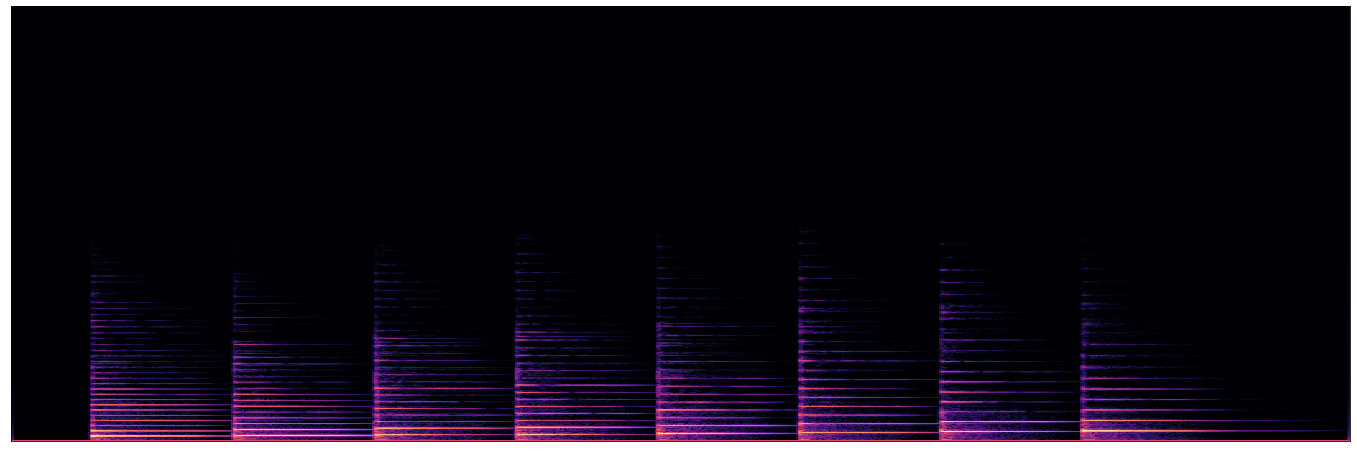

In [4]:
stft_p = lr.stft(y=(y_p + 0.02))

mag_stft_p = np.abs(stft_p)

gamma = 10
mag_stft_gamma_p = np.log10(1 + mag_stft_p * gamma)

plt.figure(figsize=(24, 8))
lr.display.specshow(mag_stft_gamma_p)
plt.show()

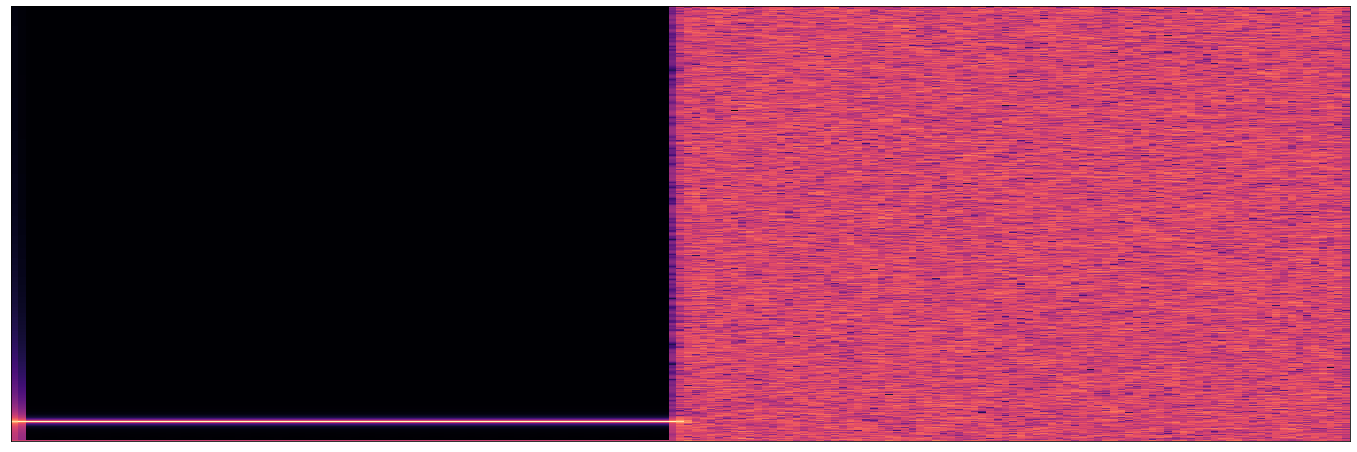

In [5]:
length = 2
freq = 500
t = np.linspace(0, length, sr * length // 2)

y_sn = np.concatenate([
    np.sin(t * 2 * np.pi * freq),
    np.random.random(sr * length // 2) * 2 - 1
]) # sinus-noise

display(Audio(y_sn, rate=sr))

stft_sn = lr.stft(y=(y_sn + 0.02))

mag_stft_sn = np.abs(stft_sn)

gamma = 10
mag_stft_gamma_sn = np.log10(1 + mag_stft_sn * gamma)

plt.figure(figsize=(24, 8))
lr.display.specshow(mag_stft_gamma_sn)
plt.show()

## Spectral Centroid

Schwerpunkt der Magnituden-Frequenzen im FFT-Fenster.

$\mathrm{spectral\ centroid} = \dfrac{\sum^{N / 2}_{k = 0} \left( X[k] \cdot f_{coef}[n] \right)}{\sum^{N / 2}_{k = 0} \left( X[k] \right)}$

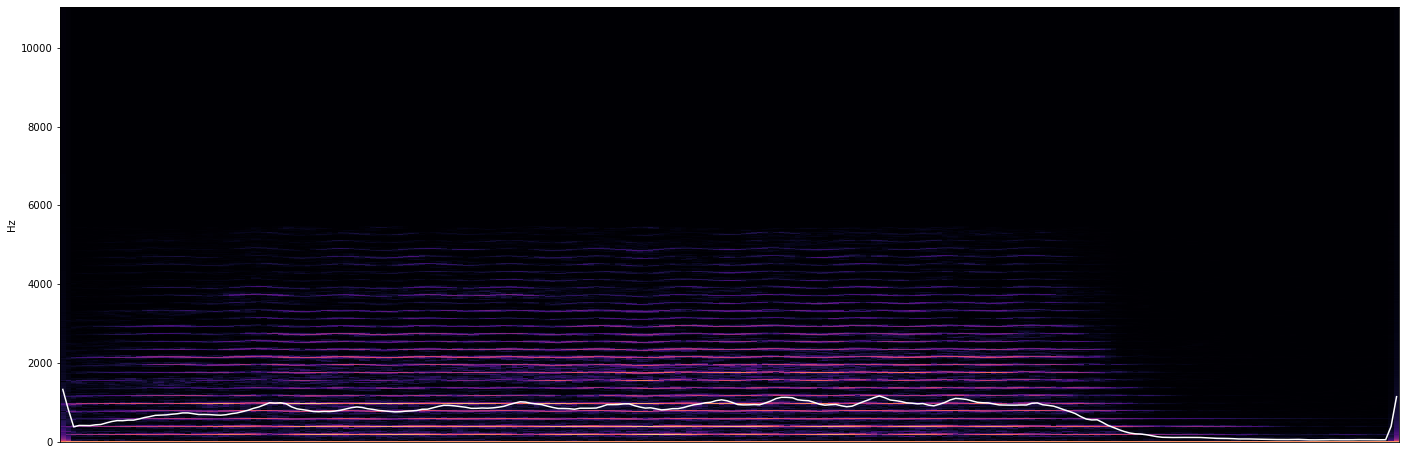

In [6]:
spec_cent_v = lr.feature.spectral_centroid(S=mag_stft_v)

plt.figure(figsize=(24, 8))
lr.display.specshow(mag_stft_gamma_v, y_axis='linear')
plt.plot(spec_cent_v[0], 'w')
plt.show()

## Spectral Bandwidth

Deutet die "Breite", bzw. Verteilung der energiereichen/energie-gleichen Frequenzkoeffizienten des Spektrums zu einem Zeitpunkt im Fenster an.

$\mathrm{spectral\ bandwidth} = \sqrt{\dfrac{\sum_{n = 0}^{N/2} \left( (f_{coef}[n] - \mathrm{spec\_cent})^2 \cdot X[n] \right) }{\sum_{n = 0}^{N/2} \left( X[n] \right)}}$

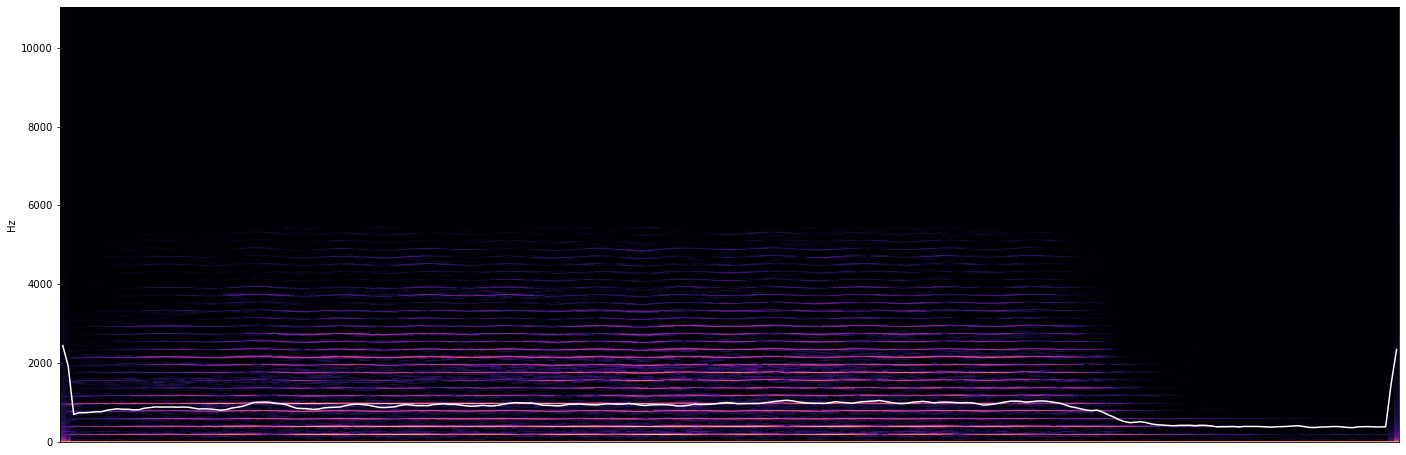

In [7]:
spec_band_v = lr.feature.spectral_bandwidth(S=mag_stft_v)

plt.figure(figsize=(24, 8))
lr.display.specshow(mag_stft_gamma_v, y_axis='linear')
plt.plot(spec_band_v[0], 'w')
plt.show()

## Bandwidth & Centroid: Kombinierte Darstellung

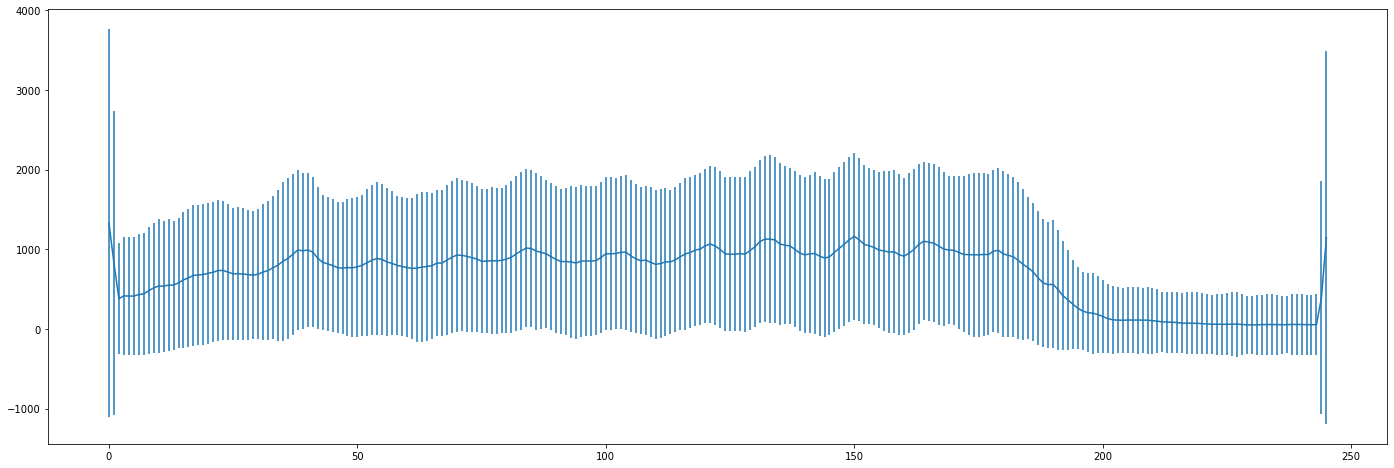

In [8]:
y_min = spec_cent_v[0] - spec_band_v[0]
y_max = spec_cent_v[0] + spec_band_v[0]

plt.figure(figsize=(24, 8))
plt.vlines(np.arange(stft_v.shape[1]), y_min, y_max)
plt.plot(spec_cent_v[0])
plt.show()

## Spectral Rolloff

Zeigt den Frequenzkoeffizienten an, unter dem sich der größte Anteil Energie (z.B. 90%) im Spektrum befindet.

Grenze bei: $C \cdot \sum_{k = 0}^{N/2} \left( X[k] \right)$, wenn $C = 0.9$.

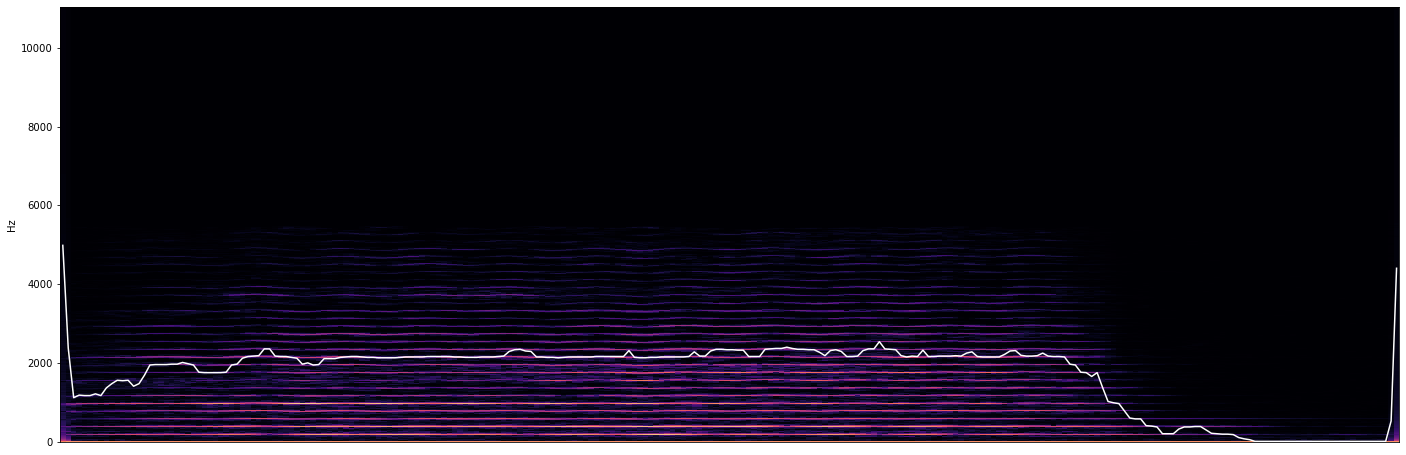

In [9]:
spec_roll_v = lr.feature.spectral_rolloff(S=mag_stft_v, roll_percent=0.9)

plt.figure(figsize=(24, 8))
lr.display.specshow(mag_stft_gamma_v, y_axis='linear')
plt.plot(spec_roll_v[0], 'w')
plt.show()

## Spectral Flatness

Wie "flach" ist das Spektrum?

--> geräuschartige Klänge: hohe Flachheit

--> (quasi-)periodische Klänge / harmonisches Spektrum: niedrige Flachheit

$\mathrm{spectral\ flatness} = \dfrac{ \exp\left(\frac{1}{N}\sum_{k = 0}^{N/2} \log(X[k]^2)\right) } { \frac{1}{N}\sum_{k = 0}^{N/2} \left( X[k]^2 \right) }$

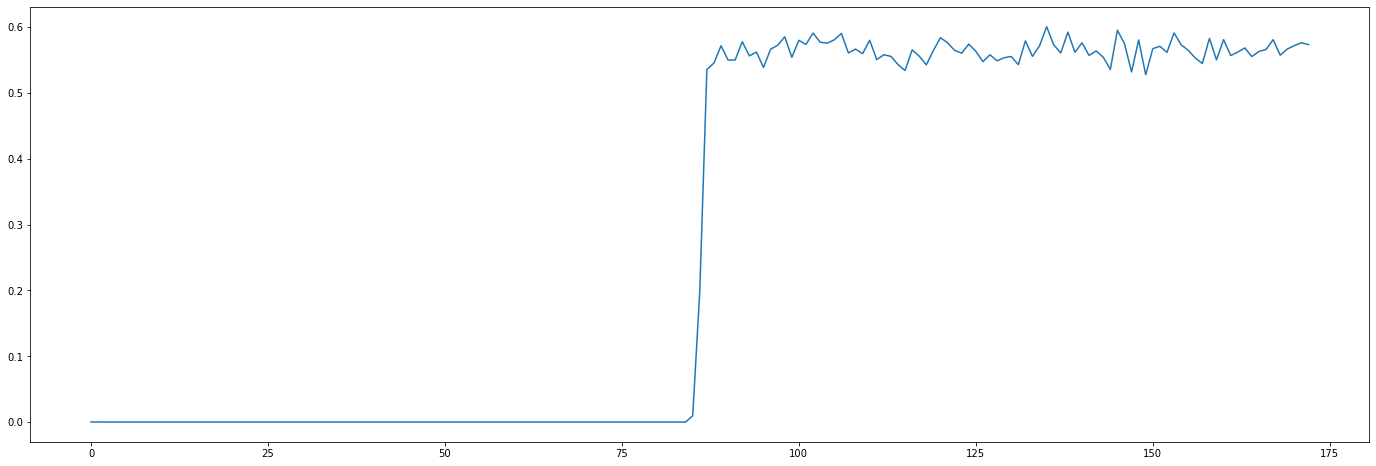

In [10]:
spec_flat_sn = lr.feature.spectral_flatness(S=mag_stft_sn)

plt.figure(figsize=(24, 8))
plt.plot(spec_flat_sn[0])
plt.show()

## Spectral Contrast

Gegenteilig zur Flatness:

--> hoher 'Contrast', wenn harmonisches Spektrum / (quasi-)periodisch

--> niedriger 'Contrast', wenn geräuschartige Klänge

Aufteilung in Sub-Bänder

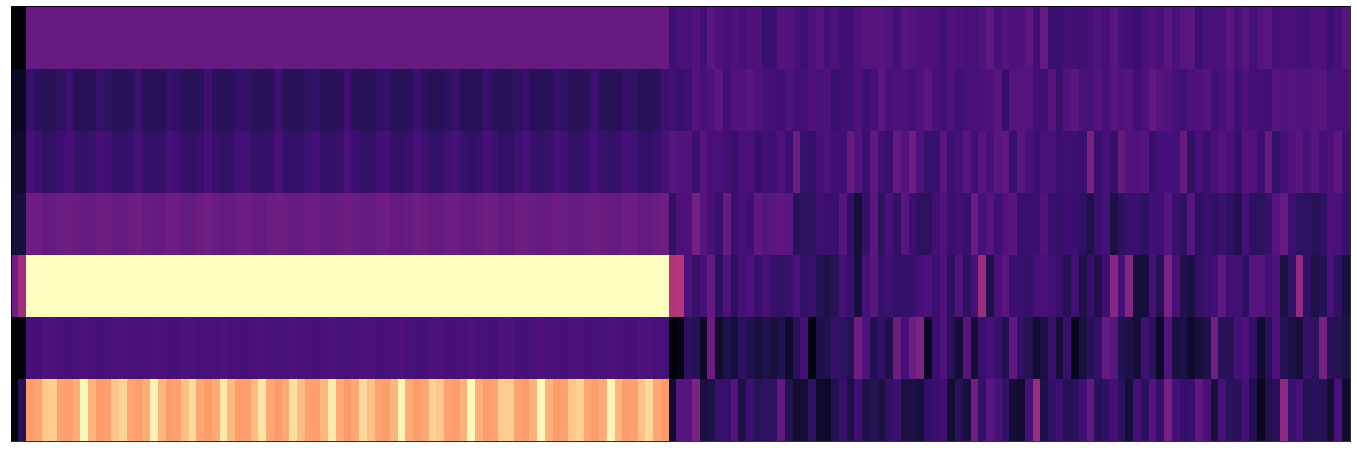

In [11]:
spec_cont_sn = lr.feature.spectral_contrast(S=mag_stft_sn)


plt.figure(figsize=(24, 8))
lr.display.specshow(spec_cont_sn)
plt.show()

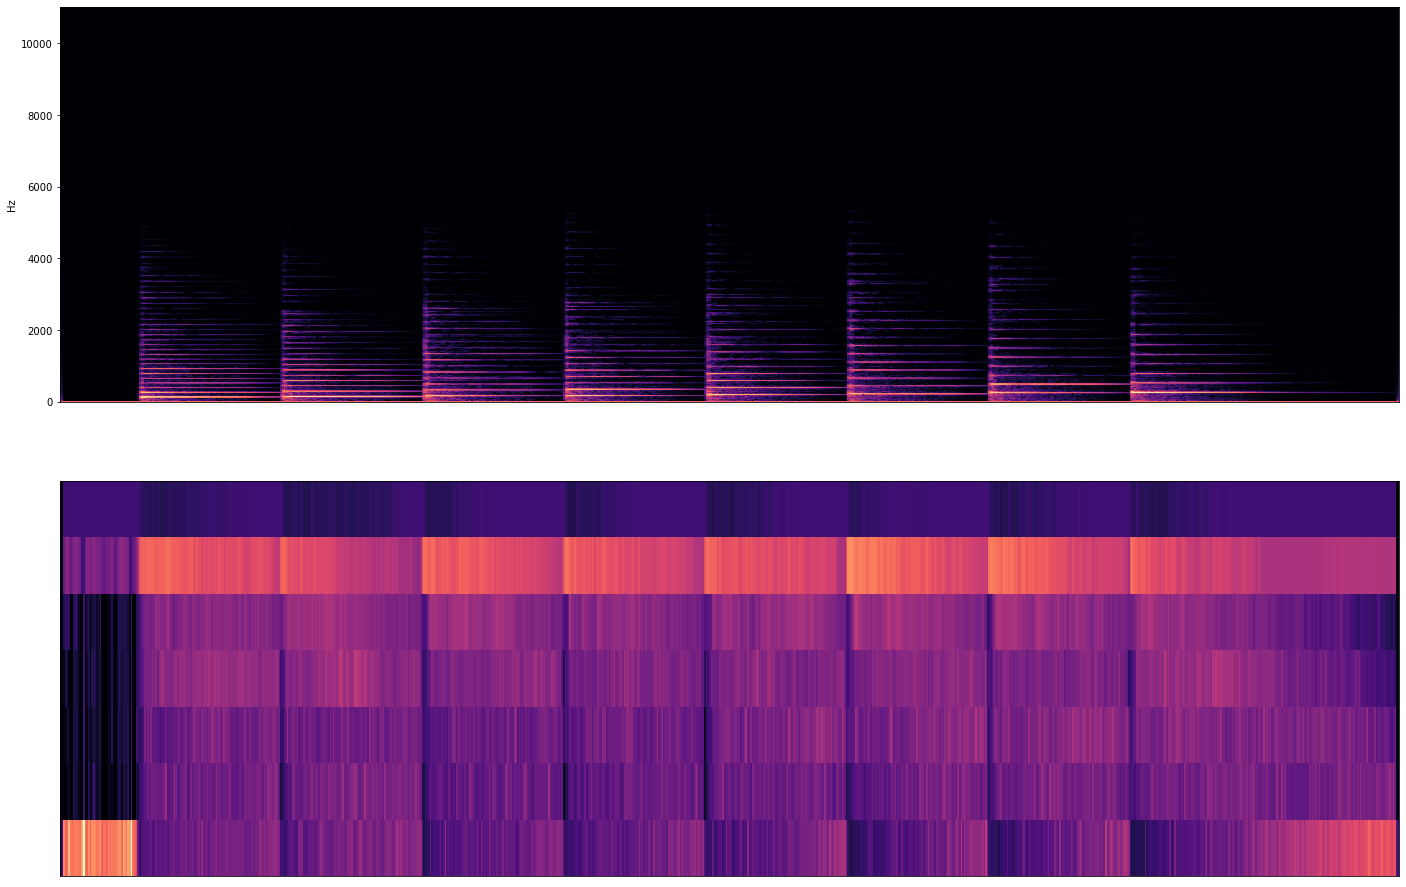

In [12]:
spec_cont_p = lr.feature.spectral_contrast(S=mag_stft_p)

plt.figure(figsize=(24, 16))
plt.subplot(2, 1, 1)
lr.display.specshow(mag_stft_gamma_p, y_axis='linear')
plt.subplot(2, 1, 2)
lr.display.specshow(spec_cont_p)
plt.show()

## MFCCs

1. STFT
2. Freq-Skalierung durch Mel-Filter-Bank (Triangular Filters)
4. Discrete Cosine Transform (DCT)
--> MFCCs Mel-Frequency-Cepstral-Coefficients

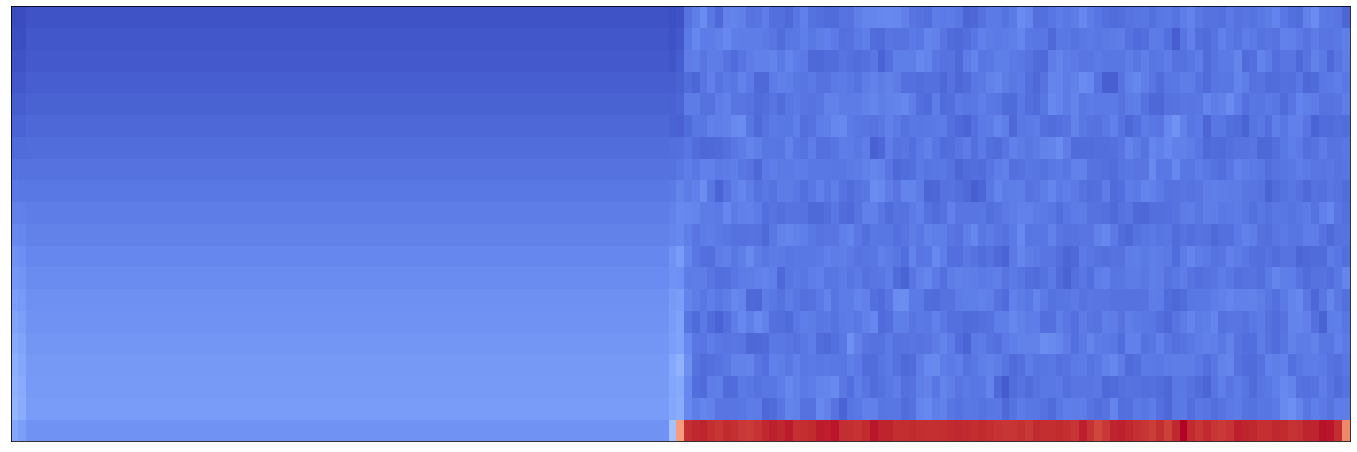

In [13]:
mfccs_sn = lr.feature.mfcc(S=mag_stft_sn)

plt.figure(figsize=(24, 8))
lr.display.specshow(mfccs_sn)
plt.show()

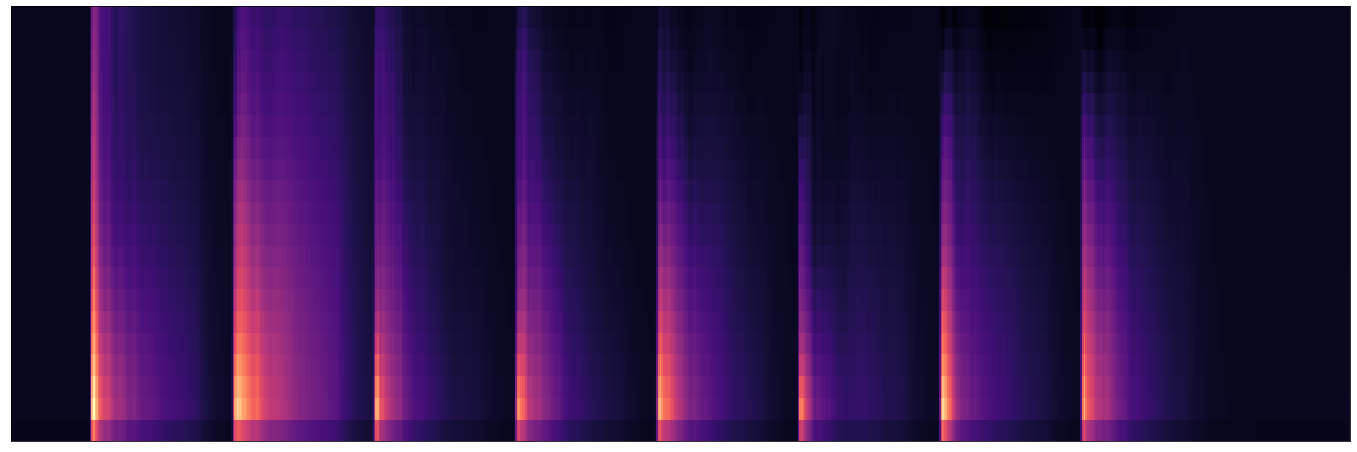

In [14]:
mfccs_p = lr.feature.mfcc(S=mag_stft_p)

plt.figure(figsize=(24, 8))
lr.display.specshow(mfccs_p)
plt.show()

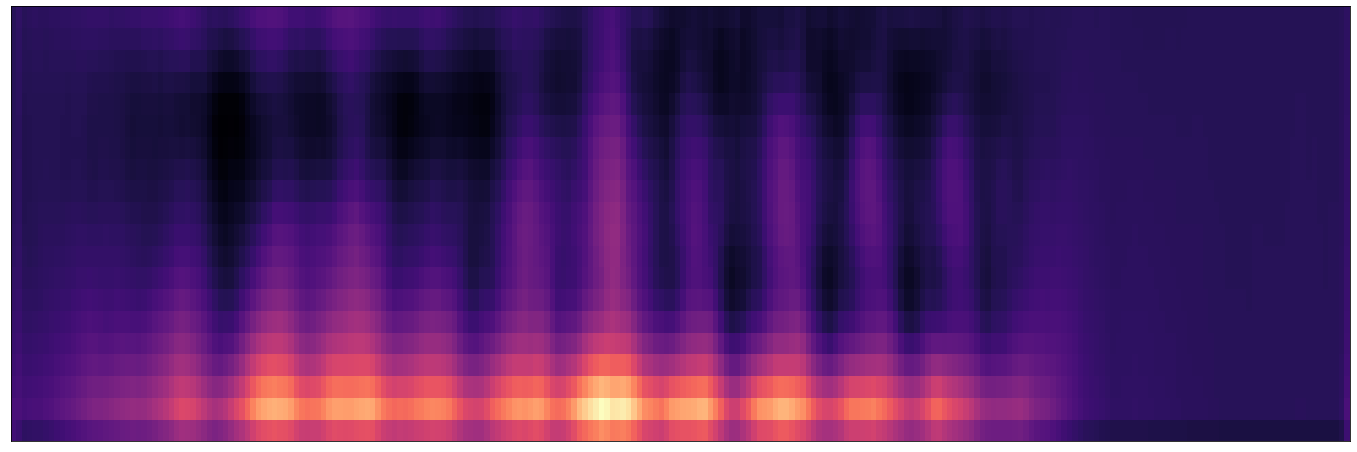

In [15]:
mfccs_v = lr.feature.mfcc(S=mag_stft_v)

plt.figure(figsize=(24, 8))
lr.display.specshow(mfccs_v)
plt.show()